In [1]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
(train_ds, val_ds, test_ds) , metadata = tfds.load('tf_flowers' , 
                                                   split=['train[:80%]','train[80%:90%]','train[90%:]'],
                                                     as_supervised=True,
                                                    with_info=True)

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


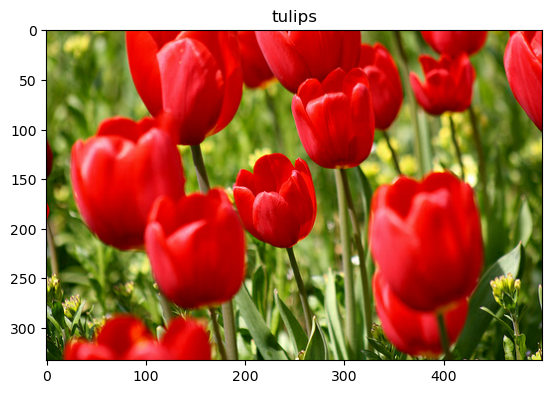

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [5]:
num_classes

5

## resize and preprocessing data argument

### methode hight level

In [8]:
image_size = 180

image_resiz_scaling = tf.keras.Sequential([
    tf.keras.layers.Resizing(image_size,image_size),
    tf.keras.layers.Rescaling(1.0/255)
])

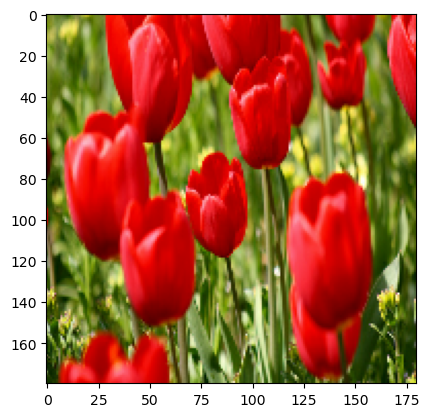

In [9]:
result = image_resiz_scaling(image)
_=plt.imshow(result)

In [10]:
print(f'min range: {result.numpy().min()}, max range: {result.numpy().max()}')

min range: 0.0, max range: 1.0


In [11]:
data_argument = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

To add a batch dimension to this image, we do the following.

In [13]:
image_batch = tf.cast(tf.expand_dims(result,0),tf.float32)

Showing the performance of data augmentation

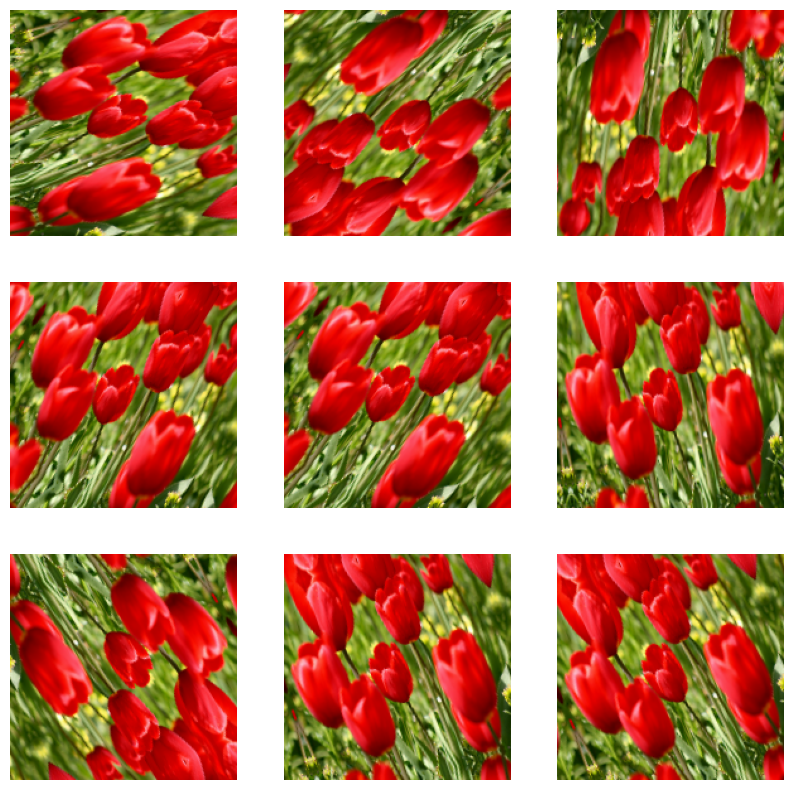

In [15]:
plt.figure(figsize=(10,10))

for i in range (9):
    data_arument_image= data_argument(image_batch)
    ax = plt.subplot(3,3,i+1)
    _= plt.imshow(data_arument_image[0])
    plt.axis('off')

## methode 2 low level

In [ ]:
model = tf.keras.Sequential([
    # We can include it directly inside the model
    # In this case, it’s applied in parallel on the GPU, which is faster
    # When we save the model and want to use it elsewhere, it is conveniently stored inside the model file and can be used somewhere else
    image_resiz_scaling,
    data_argument,
    tf.keras.layers.Conv2D(filters=20, kernel_size=2, strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2)
    # ...
])


## Note

We use these data augmentation and resizing layers only for training data, not for testing. If we add them directly to the model, Keras is smart enough to recognize that these two layers are meant for training and will not apply them during testing (inference) automatically.

If we want to use them outside the model, we map them to the dataset as follows:

> We only use these data augmentation and resizing operations for training data, not for test data. If we add such layers to the model, Keras automatically detects that these layers should not be applied during testing, so they are only active during training.  
>  
> However, if you want to use them outside of the model, you can map them to your data pipeline like this:
>
> ```python
> train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
> ```
> Or for resizing:
> ```python
> train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y))
> ```
> This way, the preprocessing is done on the dataset using the map function, and you can control exactly where and when each operation is applied.[1][2]



In [ ]:
# training=True
# The code above is meant to apply these operations only to the training data, so we won’t have problems with the test data later on.
argu_ = train_ds.map(
    lambda x,y: (image_resiz_scaling(x,training=True),y)
)

If we want a function that automatically handles these operations, we can use the following approach.

In [33]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (image_resiz_scaling(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_argument(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [35]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Now, if we check, we’ll see that it’s no longer used within the model.

In [38]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.3187 - loss: 1.6420 - val_accuracy: 0.5886 - val_loss: 1.0949
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5426 - loss: 1.1277 - val_accuracy: 0.5913 - val_loss: 1.0650
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.5876 - loss: 1.0182 - val_accuracy: 0.6458 - val_loss: 0.9649
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6383 - loss: 0.9081 - val_accuracy: 0.6540 - val_loss: 0.9522
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.6525 - loss: 0.9015 - val_accuracy: 0.6322 - val_loss: 0.9454


In [43]:
loss , acc = model.evaluate(test_ds)
print(loss , acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6235 - loss: 0.9771 
0.9443486332893372 0.640326976776123


We want to implement a function that randomly inverts half of the images.

In [44]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

If we want it as a layer, we use this approach.

In [45]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

In [46]:
random_invert

<Lambda name=lambda, built=False>

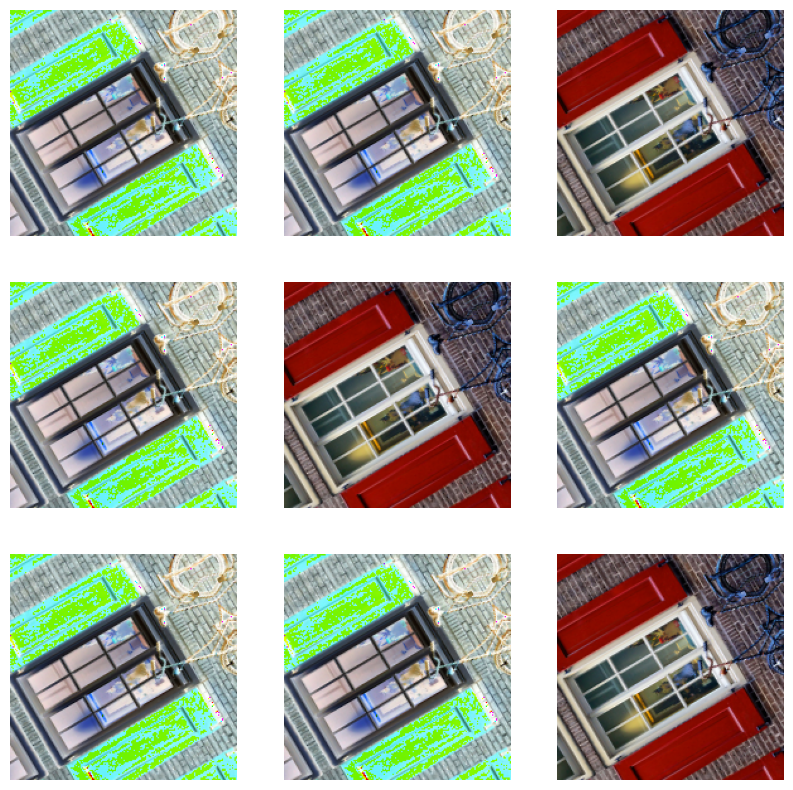

In [62]:
# فرض بر این است که train_ds از قبل بارگذاری شده
for image_batch, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = random_invert(image_batch)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((augmented_image[0] * 255).numpy().astype("uint8"))  # بازگرداندن به مقیاس 0-255
        plt.axis("off")
    plt.show()

In [100]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

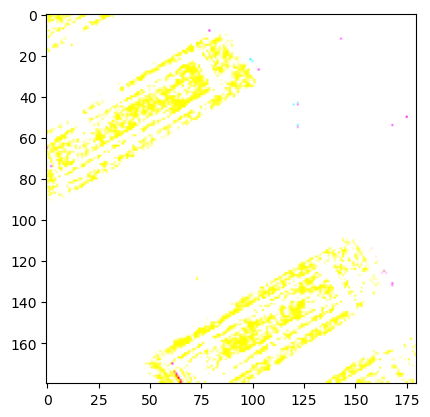

In [102]:
_ = plt.imshow(RandomInvert()(image_batch)[0])

بصورت مپ هم می توانیم بدهیم

حالا یه کار جدید 

In [107]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

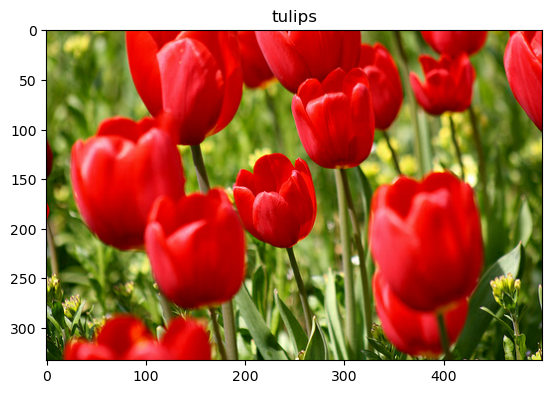

In [122]:
image , label = next(iter(train_ds))

global_name = metadata.features['label'].int2str

_=plt.imshow(image)
_= plt.title(global_name(label))

In [152]:
def visualize (orginal, augment):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(orginal)

    plt.subplot(1,2,2)
    plt.title('augment image')
    plt.imshow(augment)
    plt.axis('off')

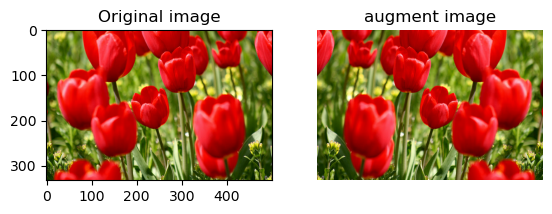

In [154]:
flipped = tf.image.flip_left_right(image)
visualize(image,flipped)

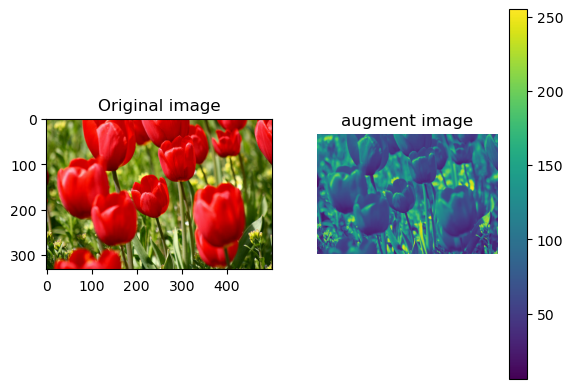

In [169]:
gray_scale = tf.image.rgb_to_grayscale(image)
visualize(image,tf.squeeze(gray_scale))
_ = plt.colorbar()

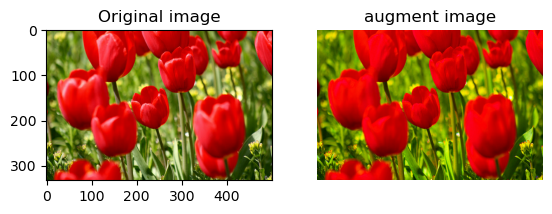

In [186]:
saturation= tf.image.adjust_saturation(image,4)
visualize(image,tf.squeeze(saturation))

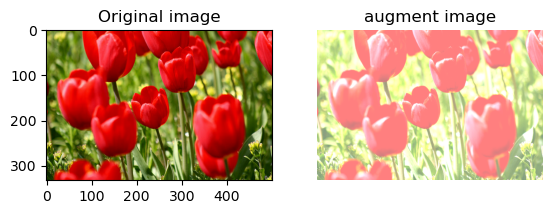

In [196]:
brightness = tf.image.adjust_brightness(image,0.5)
visualize(image,tf.squeeze(brightness))

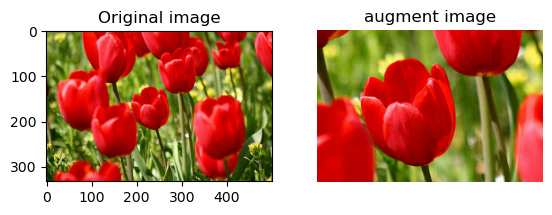

In [205]:
central_crop = tf.image.central_crop(image,central_fraction = 0.4)
visualize(image,tf.squeeze(central_crop))

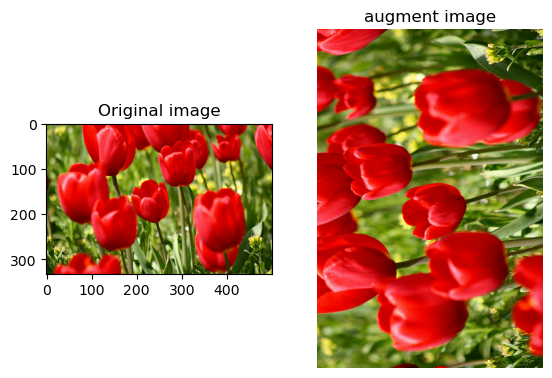

In [207]:
rot90_ = tf.image.rot90(image)
visualize(image,tf.squeeze(rot90_))

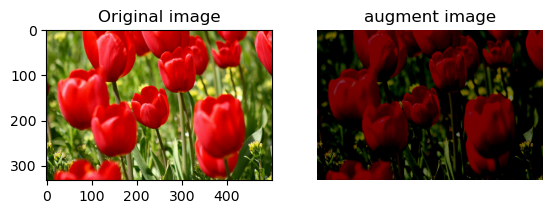

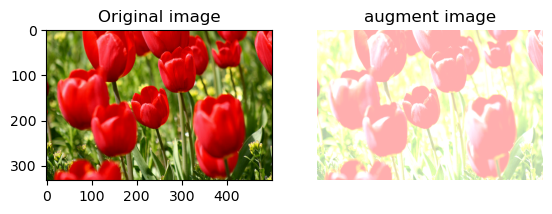

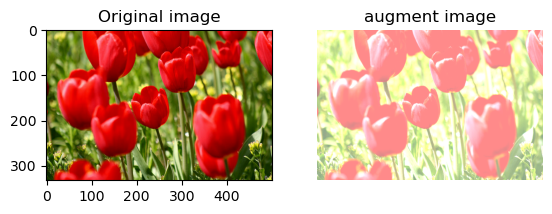

In [238]:
for i in range (3):
    seed = (i,0)
    st_rd_br = tf.image.stateless_random_brightness(image,max_delta=0.9,seed=seed)
    visualize(image,tf.squeeze(st_rd_br))

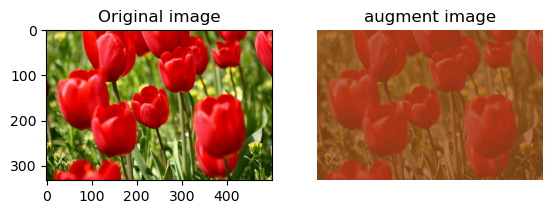

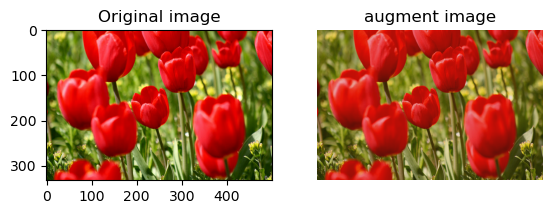

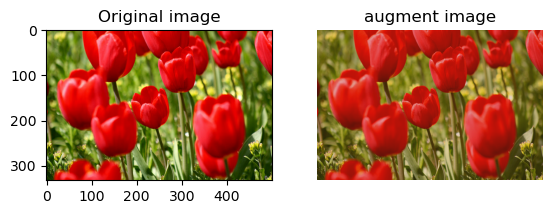

In [243]:
for i in range (3):
    seed = (i,0)
    st_rd_con = tf.image.stateless_random_contrast(image,lower=0.1, upper=0.9, seed=seed)

    visualize(image,tf.squeeze(st_rd_con))

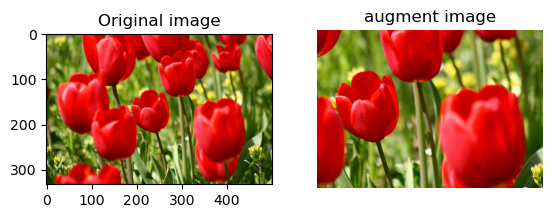

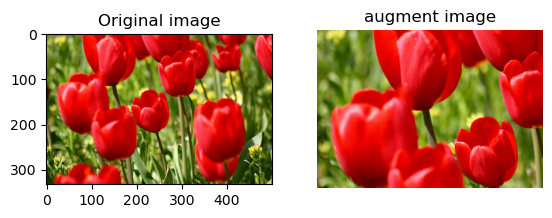

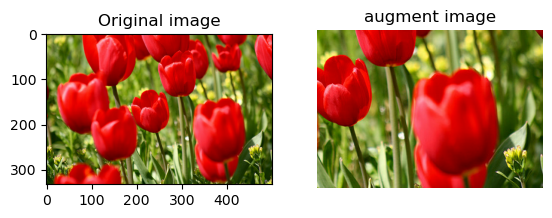

In [246]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

In [249]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

do this randomly for all

In [261]:
def resize (image , label):
    image_resize =tf.cast(image,tf.float32)
    image_resized = tf.image.resize(image_resize,size=[image_size, image_size])
    image_resized_scale = (image_resized/255.0)
    return image , label

In [291]:
def agument (image_label , seed):
    image , label = image_label
    image , label = resize(image , label)
    image = tf.image.resize_with_crop_or_pad(image, target_height = image_size, target_width = image_size)
    #new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0,:]
    image = tf.image.stateless_random_crop(
              image, size=[image_size, image_size, 3], seed=seed)
      # Random brightness.
    image = tf.image.stateless_random_brightness(
                image, max_delta=0.5, seed=new_seed)
    #کد زیر نیمذاره اعدادی تولیدی برای عکس بیشتر از 0 و 1 بشن که از استانداری که ما درست کردیم خارج بشن
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [293]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [295]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(agument, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [301]:
val_ds = (
    val_ds
    .map(resize, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [303]:
test_ds = (
    test_ds
    .map(resize, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)